In [610]:
#!/usr/bin/env python
# intrinsic_scan.py (runs offline)
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr

# ---------- 0. Load data (with unit correction) ----------
data1 = [
  [12.95e-05/61, 4.88/61, 0.085*3600, 0.199*3600],
  [17.55e-05/61, 7.20/61, 0.203*3600, 0.383*3600],
  [40e-05/61,  47.05/61, 13.954*3600, 4.325*3600],
  [41.71e-05/61, 149.48/61, 2.108*3600, 0.05*3600],
  [28.82e-05/61, 186.27/61, 8.362*3600, 7.148*3600]
]
data2 = [
  [8.2869e-04/16, 3.5460e-05/16, 1e2, 8.7568e2],
  [7.5882e-04/16, 1.8729e-05/16, 2.1114e4, 1e5],
  [5.6219e-04/16, 2.5990e-05/16, 1e5, 1.2035e4],
  [2.6501e-03/16, 1.5436e-05/16, 7.1261e3, 1e5],
  [2.1924e-03/16, 1.0e-05/16,  6.6772e3, 1e5],
  [3.4846e-04/16, 1.0161e-04/16, 1e5, 8.87e3],
  [1.3818e-03/16, 7.2978e-05/16, 2.2678e4, 1.1335e4],
  [2.0129e-02/16, 1.0e-05/16,  1.8136e4, 1e5],
  [4.0756e-03/16, 4.1385e-05/16, 5.4657e4, 1e5],
  [3.0194e-04/16, 1.0880e-04/16, 9.3494e4, 6.6447e3],
  [2.0738e-04/16, 1.0245e-04/16, 7.52e4, 7.401e3],
  [3.5918e-04/16, 1.1202e-04/16, 2.7953e4, 4.1137e3]
]
df = pd.DataFrame(data1+data2, columns=["Ss","K","tau_q","tau_h"]).dropna()
df.loc[df.index < 5,"K"] /= 86400.  # m²/day → m²/s
vars_all = ["Ss","K","tau_q","tau_h"]

# ---------- 1. log10 variables ----------
logdf = np.log10(df[vars_all])
labels = [f"log_{v}" for v in vars_all]
logdf.columns = labels

# ---------- 2A. Correlation & MI heat map ----------
pear = logdf.corr(method="pearson")
spear = logdf.corr(method="spearman")
mi_mat = pd.DataFrame(np.zeros_like(pear), columns=labels, index=labels)
for i,c1 in enumerate(labels):
  for j,c2 in enumerate(labels):
    mi_mat.iloc[i,j] = mutual_info_regression(
      logdf[[c1]].values, logdf[c2].values, random_state=0)[0]

# ---------- 2B. PCA loading (view variable clusters) ----------
pca = PCA(n_components=2).fit(StandardScaler().fit_transform(logdf))
load = pca.components_.T  # coefficient for each variable in PC1/PC2

# ---------- 3. RF + Permutation importance ----------
X = logdf[["log_K","log_Ss"]].values
RF = RandomForestRegressor(n_estimators=500, random_state=0)
feat_imp = {}
for target in ["log_tau_q","log_tau_h"]:
  RF.fit(X, logdf[target])
  pi = permutation_importance(RF, X, logdf[target], random_state=0, n_repeats=200)
  feat_imp[target] = pi.importances_mean




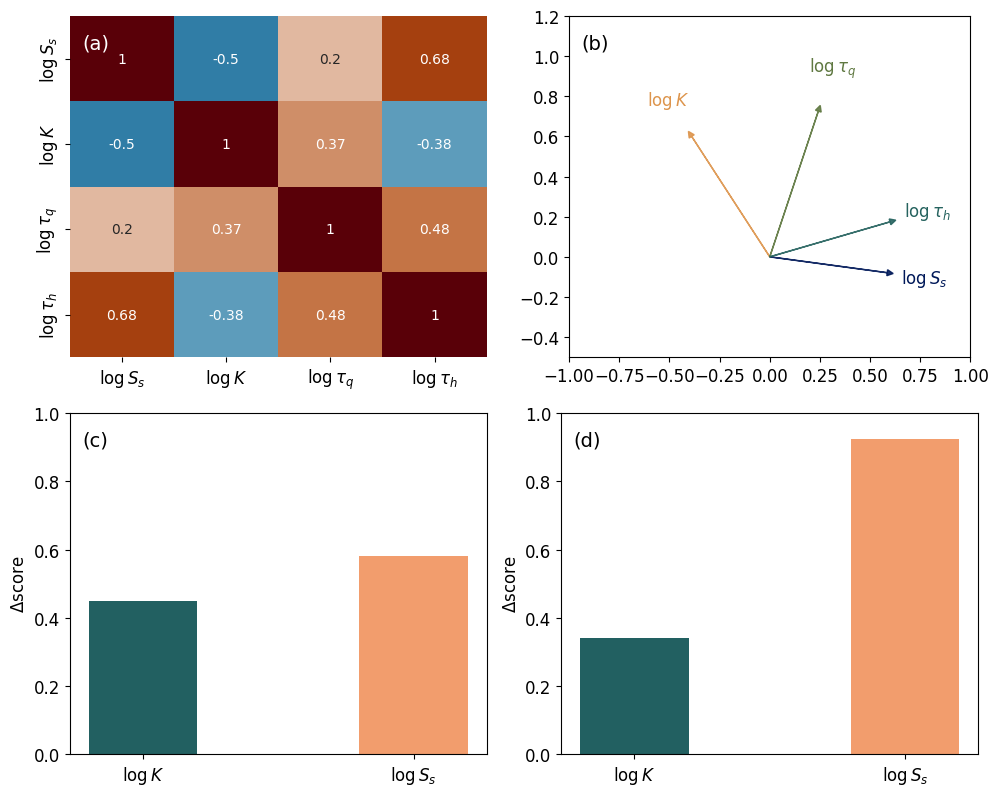

In [612]:
pretty = {
  "log_Ss"   : r'$\log S_s$',
  "log_K"   : r'$\log K$',
  "log_tau_q" : r'$\log \tau_q$',
  "log_tau_h" : r'$\log \tau_h$'
}


import matplotlib as mpl
mpl.rcParams.update({
  'axes.titlesize' : 12,  # subplot title size
  'axes.labelsize' : 12,  # x/y axis title size
  'xtick.labelsize' : 12,  # x-axis tick font
  'ytick.labelsize' : 12  # y-axis tick font
})


# ---------- 4. single 2×2 panel ----------
fig = plt.figure(figsize=(10,8))

# (a) Pearson heat ───────────────
ax = fig.add_subplot(2,2,1)
sns.heatmap(pear, annot=True, vmin=-1, vmax=1,
      cmap=cmc.vik, ax=ax, cbar=False,
      xticklabels=[pretty[l] for l in labels],
      yticklabels=[pretty[l] for l in labels])
ax.text(0.03, 0.95, "(a)", transform=ax.transAxes,
    fontsize=14, va="top", color='w')


# ---------- (b) PCA loading ───────────────────────────
ax2 = fig.add_subplot(2, 2, 2)

colors = cmc.batlowS(np.linspace(0.0, 0.5, len(labels))) # 4 gradient colors
for i, lbl in enumerate(labels):             # labels = ["log_S", …]
  ax2.arrow(0, 0,
       load[i, 0], load[i, 1],
       head_width=0.03, head_length=0.03,
       length_includes_head=True,
       color=colors[i], alpha=0.9)
  ax2.text(load[i, 0] * 1.25,
       load[i, 1] * 1.25,
       pretty[lbl], fontsize=12,
       ha="center", va="center", color=colors[i])

ax2.set_xlim(-1, 1); ax2.set_ylim(-0.5, 1.2)
ax2.set_aspect("equal")
#ax2.grid(True, ls="--", lw=0.4, alpha=0.6)
ax2.text(0.03, 0.95, "(b)",
     transform=ax2.transAxes,
     fontsize=14, va="top")



# ---------- (c) Perm-imp τ_q ───────────────────────────
ax3 = fig.add_subplot(2, 2, 3)
bar_width=0.4
bars_q = ax3.bar(
  [pretty["log_K"], pretty["log_Ss"]],       # x label replaced by LaTeX
  feat_imp["log_tau_q"],
    width=bar_width,             # delta score value
  color=cmc.batlow(np.linspace(0.25, 0.75, 2))   # two-step batlow color
)
ax3.text(0.03, 0.95, "(c)",
     transform=ax3.transAxes,
     fontsize=14, va="top")
ax3.set_ylim(0, 1)
ax3.set_ylabel("$\\Delta$score", fontsize=12)

# ---------- (d) Perm-imp τ_h ───────────────────────────
ax4 = fig.add_subplot(2, 2, 4)

bars_h = ax4.bar(
  [pretty["log_K"], pretty["log_Ss"]],
  feat_imp["log_tau_h"],
    width=bar_width, 
  color=cmc.batlow(np.linspace(0.25, 0.75, 2))
)
ax4.text(0.03, 0.95, "(d)",
     transform=ax4.transAxes,
     fontsize=14, va="top")
ax4.set_ylim(0, 1)
ax4.set_ylabel("$\\Delta$score", fontsize=12)


plt.tight_layout()
fig.savefig('Intr.pdf',     # filename + extension determine format
      dpi=300,         # resolution (dpi), default 100
      bbox_inches='tight',   # auto trim whitespace
      transparent=False)  
plt.show()

In [614]:
# ------------------------------------------------------------
# utility：list each variable angle in PC1–PC2 plane (deg) and Pearson r
# ------------------------------------------------------------
import itertools, numpy as np, pandas as pd
from math import acos, degrees

def angle_between(u, v):
  # vectors may be scaled, divide by projection length first
  dot = np.dot(u, v)
  norm_prod = np.linalg.norm(u) * np.linalg.norm(v)
  return degrees(acos(np.clip(dot / norm_prod, -1, 1)))

def print_angle_table(load, var_names, pear_mat):
  rows = []
  for i, j in itertools.combinations(range(len(var_names)), 2):
    ang = angle_between(load[i], load[j])
    r  = pear_mat.iloc[i,j]
    rows.append([var_names[i], var_names[j], f"{ang:6.1f}", f"{r:5.2f}"])
  tbl = pd.DataFrame(rows, columns=["var-1","var-2","angle (°)","Pearson r"])
  print("\n=== PCA-plane angle vs. Pearson r ===")
  print(tbl.to_string(index=False))

# ----------------- place appropriately in main program -----------------
# load = pca.components_.T # your precomputed 4×2 matrix
print_angle_table(load, labels, pear)   # labels e.g. ["log_S","log_T","log_tau_q","log_tau_h"]



=== PCA-plane angle vs. Pearson r ===
    var-1     var-2 angle (°) Pearson r
   log_Ss     log_K     130.7     -0.50
   log_Ss log_tau_q      79.3      0.20
   log_Ss log_tau_h      23.9      0.68
    log_K log_tau_q      51.4      0.37
    log_K log_tau_h     106.7     -0.38
log_tau_q log_tau_h      55.3      0.48


In [473]:
# ──────────────────────────────────────
#  Step 6 — Sobol with log τ & batlow
# ──────────────────────────────────────
from SALib.sample import sobol   # new API
from SALib.analyze import sobol as sa
import cmcrameri.cm as cmc, numpy as np, pandas as pd, matplotlib.pyplot as plt, warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# 1. obtain β0, β1 (pooled log–log regression)
m, b0, *_ = st.linregress(np.log10(df['x_ind']), np.log10(df['theta']))
β1, β0 = m, b0

# 2. median + bounds (log τ use ±0.021 ≈ CV 5%)
k0, ss0, n0 = df['K'].median(), df['S_s'].median(), df['n'].median()
tq0, th0   = df['tau_q'].median(), df['tau_h'].median()
dlogτ    = np.log10(1.05)    # ≈ 0.021

problem = {
  'num_vars': 5,
  'names': ['logK', 'logS_s', 'n', 'logTau_q', 'logTau_h'],
  'bounds': [
    [np.log10(k0)-0.7, np.log10(k0)+0.7],
    [np.log10(ss0)-0.5, np.log10(ss0)+0.5],
    [n0*0.95,      n0*1.05],
    [np.log10(tq0)-dlogτ, np.log10(tq0)+dlogτ],
    [np.log10(th0)-dlogτ, np.log10(th0)+dlogτ],
  ]
}

# 3. sampling and model
np.random.seed(101)
N = 2048             # 2^11 → Sobol convergence
X = sobol.sample(problem, N, calc_second_order=False)

def model(X):
  logK, logSs, n, logTq, logTh = X.T
  K, Ss   = 10**logK, 10**logSs
  tau_q, tau_h = 10**logTq, 10**logTh
  theta   = (tau_h / tau_q) * (10**β0) * ((g * n) / (Ss * K**2))**β1
  return theta

Y = model(X)
Si = sa.analyze(problem, Y, calc_second_order=False)

# 4. plotting: batlow gradient + no frame
cmap  = cmc.batlow
colors = [cmap(x) for x in np.linspace(0.15, 0.85, len(problem['names']))]

pretty = {'logK': r'$K$',
     'logS_s': r'$S_s$',
     'n': r'$n$',
     'logTau_q': r'$\tau_q$',
     'logTau_h': r'$\tau_h$'}
yticks = [pretty[n] for n in problem['names']]


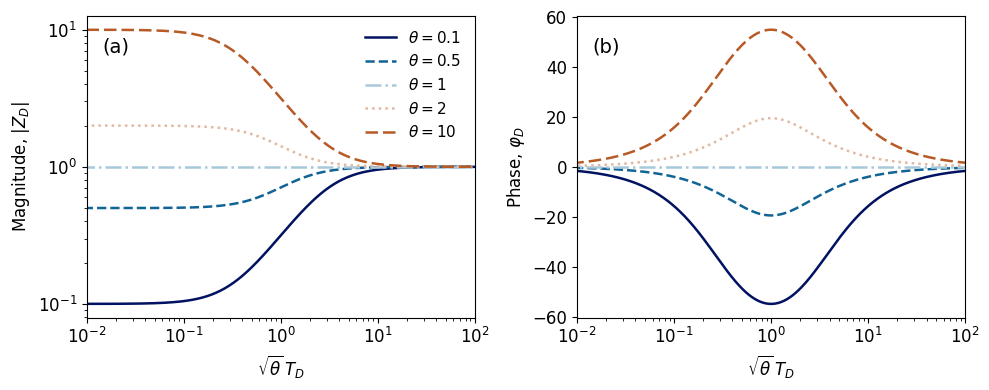

In [353]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
try:
  import cmcrameri.cm as cmc
  cmap = cmc.vik
except ImportError:
  cmap = mpl.cm.get_cmap('viridis')

theta_set = np.array([0.1, 0.5, 1, 2, 10])
linestyles = ['-', '--', '-.', ':', (0, (5, 2))]
tau_star  = np.logspace(-3, 3, 400)    # τ* = 1/(ω τ_q)
colors   = cmap(np.linspace(0, 0.8, theta_set.size))

# precompute global ξ range: ξ = √θ / τ*
xi_all = np.outer(1/ tau_star, np.sqrt(theta_set))  # shape (400, 5)
x_min, x_max = xi_all.min(), xi_all.max()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))   # no sharex

for th, col, ls in zip(theta_set, colors, linestyles):
  xi = tau_star / np.sqrt(th)           # correct ξ
  Z = (1 + 1j*th / tau_star) / (1 + 1j / tau_star)
  axes[0].plot(xi, np.abs(Z),  color=col, ls=ls, lw=1.8,
         label=fr'$\theta={th:g}$')
  axes[1].plot(xi, np.angle(Z, deg=True),
         color=col, ls=ls, lw=1.8)
  axes[0].set_xlim(1e-2, 1e2)
  axes[1].set_xlim(1e-2, 1e2)

for ax, lab, tag in zip(
    axes, [r'Magnitude, $|Z_D|$', r'Phase, $\varphi_D$'], ['(a)', '(b)']):
  ax.set_xscale('log')
  #ax.set_xlim(x_min, x_max)            # force same range for both plots
  ax.set_xlabel(r'$\sqrt{\theta}\,T_D$', fontsize=12)
  ax.set_ylabel(lab, fontsize=12)
  ax.text(0.04, 0.93, tag, transform=ax.transAxes,
      ha='left', va='top', fontsize=14)
  
  ax.tick_params(axis='both', labelsize=12)

axes[0].set_yscale('log')
axes[0].legend(frameon=False, fontsize=11)

plt.tight_layout()
fig.savefig('A_phi.pdf',     # filename + extension determine format
      dpi=300,         # resolution (dpi), default 100
      bbox_inches='tight',   # auto trim whitespace
      transparent=False)  
plt.show()


In [502]:
# ==============================================================
# 0. packages & I/O
# ==============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, rankdata
from scipy.spatial import cKDTree
from scipy.linalg import cho_factor, cho_solve
from skgstat import Variogram     # scikit-gstat
import rasterio
from rasterio.transform import from_origin
from skgstat import Variogram  # pip install scikit-gstat
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree, distance
from scipy.stats import norm
from pykrige.ok import OrdinaryKriging  # let copula_bme auto-estimate variance
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm, rankdata
from scipy.spatial import cKDTree
from scipy.spatial.distance import cdist
from scipy.interpolate import interp1d
from scipy.linalg import cho_factor, cho_solve

# ---------- user modification section ----------
CSV_COORD = 'Well location.csv'  # (x,y) two columns, no header
B_LAYER  = 20.0         # aquifer thickness (m)
T_FIELD_S = 24*3600        # pumping lasts 24 h
NX, NY  = 200, 200       # grid resolution
# -----------------------------------

# ==============================================================
# 1. read file + parameter table
# ==============================================================
well = pd.read_csv(CSV_COORD, header=None, names=['x', 'y'])

well.index = [
  'MW-13','MW-12','MW-10','MW-08','MW-09','Pumping',
  'MW-11','MW-05','MW-06','MW-07','MW-03','MW-04','MW-02','MW-01'
]

par_raw = [
  [8.2869e-04, 3.5460e-05, 1.0000e+02, 8.7568e+02],
  [7.5882e-04, 1.8729e-05, 2.1114e+04, 1.0000e+05],
  [5.6219e-04, 2.5990e-05, 1.0000e+05, 1.2035e+04],
  [2.6501e-03, 1.5436e-05, 7.1261e+03, 1.0000e+05],
  [np.nan,   np.nan,   np.nan,   np.nan   ],  # MW-09
  [2.1924e-03, 1.0000e-05, 6.6772e+03, 1.0000e+05],
  [3.4846e-04, 1.0161e-04, 1.0000e+05, 8.8700e+03],
  [1.3818e-03, 7.2978e-05, 2.2678e+04, 1.1335e+04],
  [2.0129e-02, 1.0000e-05, 1.8136e+04, 1.0000e+05],
  [4.0756e-03, 4.1385e-05, 5.4657e+04, 1.0000e+05],
  [3.0194e-04, 1.0880e-04, 9.3494e+04, 6.6447e+03],
  [2.0738e-04, 1.0245e-04, 7.5200e+04, 7.4010e+03],
  [3.5918e-04, 1.1202e-04, 2.7953e+04, 4.1137e+03],
  [np.nan,   np.nan,   np.nan,   np.nan   ]  # Pump-well
]
prm = pd.DataFrame(par_raw, columns=['S','T','tau_q','tau_h'],
          index=well.index)
well = pd.concat([well, prm], axis=1).dropna()

# convert back to K (T = K·b)
well['K'] = well['T'] / B_LAYER
# 1. add delay ratio θ
well['theta'] = well['tau_h'] / well['tau_q']

# ==============================================================
# 2. compute energy formula
# ==============================================================
t  = T_FIELD_S
K  = well['K'].values
tq = well['tau_q'].values
th = well['tau_h'].values


rho = 1000
epsilon = 0.243

E_q = abs(rho * g *((0.5*t**2 + t*(tq-th) + th*np.exp(-t/th)*(tq-th) + th**2 - th*tq)/K) / t /3.6e6) * epsilon
E_g = abs(rho * g *(K*(0.5*t**2 + t*(th-tq) + tq*np.exp(-t/tq)*(th-tq) - th*tq + tq**2)) / t /3.6e6) * epsilon

well['E_q'] = E_q
well['E_grad'] = E_g

# take log10 before feeding to wrapper
well['log_Eq']  = np.log10(well['E_q'])
well['log_Egrad'] = np.log10(well['E_grad'])

In [453]:
# km grid (200×200; consistent with above)
xmin_km, xmax_km = well['x'].min(), well['x'].max()
ymin_km, ymax_km = well['y'].min(), well['y'].max()
xi_km = np.linspace(xmin_km, xmax_km, NX)
yi_km = np.linspace(ymin_km, ymax_km, NY)
grid_X, grid_Y = np.meshgrid(xi_km, yi_km)   # for wrapper


In [454]:
# -------- E_q ----------
df_Eq = well[['x','y','log_Eq']].copy()
df_Eq.columns = ['x','y','z']    # wrapper requires fixed column names

# -------- E_grad -------
df_Eg = well[['x','y','log_Egrad']].copy()
df_Eg.columns = ['x','y','z']


In [455]:
# ====== const-flow (E_q) =====================================
Eq_mean , Eq_median , Eq_var , Eq_hi , Eq_lo = copula_interpolation_wrapper(
  df_Eq,
  grid_X, grid_Y,
  n_neighbors    = 100,
  k         = 20000,
  variogram_lag_step= 0.1,  # km
  plot_variogram  = False
)

# ====== const-gradient (E_grad) ==============================
Eg_mean , Eg_median , Eg_var , Eg_hi , Eg_lo = copula_interpolation_wrapper(
  df_Eg,
  grid_X, grid_Y,
  n_neighbors    = 100,
  k         = 20000,
  variogram_lag_step= 0.1,
  plot_variogram  = False
)


max lag is 37.35247596415264
max lag is 37.35247596415264


In [503]:
# 2-1 build columns required for wrapper
df_th = well[['x', 'y', 'theta']].rename(columns={'theta':'z'})

# 2-2 interpolate; only mean needed here
TH_mean, *_ = copula_interpolation_wrapper(
  df_th,
  grid_X, grid_Y,
  n_neighbors    = 100,
  k         = 20000,
  variogram_lag_step= 0.1,
  plot_variogram  = False
)


max lag is 37.35247596415264


In [508]:
# 2-1 correct approach: rename "K" to "z"
df_K = well[['x', 'y', 'K']].rename(columns={'K': 'z'})

# 2-2 interpolation
K_mean, *_ = copula_interpolation_wrapper(
  df_K,
  grid_X, grid_Y,
  n_neighbors    = 100,
  k         = 20000,
  variogram_lag_step= 0.1,
  plot_variogram  = False
)


max lag is 37.35247596415264


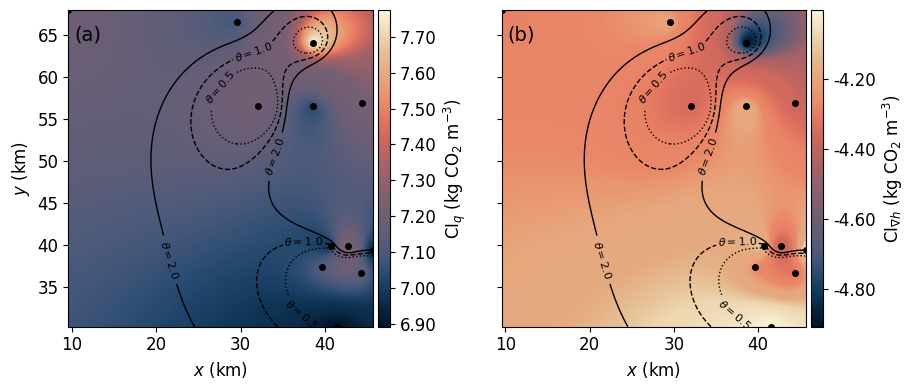

In [505]:
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cmc.lipari     # ← use batlow; revert to vik if desired
fmt = FormatStrFormatter('%.2f')   # ← 2 decimal places
ax_ticksize  = 12
cbar_ticksize = 12
cbar_labelsize= 12

# -------- 1. take logarithm ------------------------------
Eq_plot = np.log10(Eq_median)     # or Eq_mean
Eg_plot = np.log10(Eg_median)
Eq_plot = np.ma.masked_invalid(Eq_plot)
Eg_plot = np.ma.masked_invalid(Eg_plot)

theta_levels = [0.5, 1, 2]     # select 3–4 representative lines as needed
theta_styles  = [':', '--', '-']      # different line styles

fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# ------------ (a) E_q ---------------------------
im0 = ax[0].imshow(Eq_median, origin='lower',
          extent=[xmin_km,xmax_km,ymin_km,ymax_km],
          cmap=cmap)
ax[0].scatter(well['x'], well['y'], c='k', s=16)
ax[0].text(0.02, 0.95, '(a)', transform=ax[0].transAxes,
      fontsize=14, va='top')

div0 = make_axes_locatable(ax[0])        # ⬅ same-height colorbar
cax0 = div0.append_axes("right", size="4%", pad=0.05)
cbar0 = fig.colorbar(im0, cax=cax0)
cax0.yaxis.set_major_formatter(fmt)       # ⬅ decimal places
cax0.tick_params(labelsize=cbar_ticksize)
cbar0.ax.set_ylabel(r'CI$_q$ (kg CO$_2$ m$^{-3}$)',
          fontsize=cbar_labelsize)

cs0 = ax[0].contour(
    grid_X, grid_Y, TH_mean,
    levels   = theta_levels,
    colors   = ['k']*len(theta_levels),  # same color
    linestyles = theta_styles,
    linewidths = 1.0
)
ax[0].clabel(cs0, inline=True, fmt=r'$\theta=%.1f$', fontsize=8)

# ------------ (b) E_grad ------------------------
im1 = ax[1].imshow(Eg_median, origin='lower',
          extent=[xmin_km,xmax_km,ymin_km,ymax_km],
          cmap=cmap)
ax[1].scatter(well['x'], well['y'], c='k', s=16)
ax[1].text(0.02, 0.95, '(b)', transform=ax[1].transAxes,
      fontsize=14, va='top')

div1 = make_axes_locatable(ax[1])
cax1 = div1.append_axes("right", size="4%", pad=0.05)
cbar1 = fig.colorbar(im1, cax=cax1)
cax1.yaxis.set_major_formatter(fmt)
cax1.tick_params(labelsize=cbar_ticksize)
cbar1.ax.set_ylabel(r'CI$_{\nabla h}$ (kg CO$_2$ m$^{-3}$)',
          fontsize=cbar_labelsize)

cs1 = ax[1].contour(
    grid_X, grid_Y, TH_mean,
    levels   = theta_levels,
    colors   = ['k']*len(theta_levels),  # same color
    linestyles = theta_styles,
    linewidths = 1.0
)
ax[1].clabel(cs1, inline=True, fmt=r'$\theta=%.1f$', fontsize=8)
# ---- common axis label & tick size -----------------------
for a in ax:
  a.set_xlabel('$x$ (km)', fontsize=12)
  a.tick_params(axis='both', labelsize=ax_ticksize)
ax[0].set_ylabel('$y$ (km)', fontsize=12)

plt.tight_layout()
fig.subplots_adjust(wspace=0.04, left=0.07, right=0.92)
plt.savefig('CI_maps.pdf', dpi=300)  # or 
plt.show()

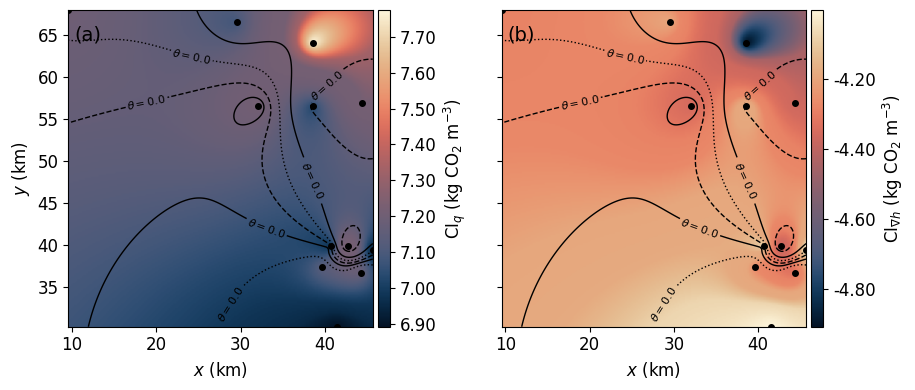

In [509]:
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cmc.lipari     # ← use batlow; revert to vik if desired
fmt = FormatStrFormatter('%.2f')   # ← 2 decimal places
ax_ticksize  = 12
cbar_ticksize = 12
cbar_labelsize= 12

# -------- 1. take logarithm ------------------------------
Eq_plot = np.log10(Eq_median)     # or Eq_mean
Eg_plot = np.log10(Eg_median)
Eq_plot = np.ma.masked_invalid(Eq_plot)
Eg_plot = np.ma.masked_invalid(Eg_plot)

theta_levels = [0.5, 1, 2]     # select 3–4 representative lines as needed
theta_styles  = [':', '--', '-']      # different line styles

fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# ------------ (a) E_q ---------------------------
im0 = ax[0].imshow(Eq_median, origin='lower',
          extent=[xmin_km,xmax_km,ymin_km,ymax_km],
          cmap=cmap)
ax[0].scatter(well['x'], well['y'], c='k', s=16)
ax[0].text(0.02, 0.95, '(a)', transform=ax[0].transAxes,
      fontsize=14, va='top')

div0 = make_axes_locatable(ax[0])        # ⬅ same-height colorbar
cax0 = div0.append_axes("right", size="4%", pad=0.05)
cbar0 = fig.colorbar(im0, cax=cax0)
cax0.yaxis.set_major_formatter(fmt)       # ⬅ decimal places
cax0.tick_params(labelsize=cbar_ticksize)
cbar0.ax.set_ylabel(r'CI$_q$ (kg CO$_2$ m$^{-3}$)',
          fontsize=cbar_labelsize)

cs0 = ax[0].contour(
    grid_X, grid_Y, K_mean,

    colors   = ['k']*len(theta_levels),  # same color
    linestyles = theta_styles,
    linewidths = 1.0
)
ax[0].clabel(cs0, inline=True, fmt=r'$\theta=%.1f$', fontsize=8)

# ------------ (b) E_grad ------------------------
im1 = ax[1].imshow(Eg_median, origin='lower',
          extent=[xmin_km,xmax_km,ymin_km,ymax_km],
          cmap=cmap)
ax[1].scatter(well['x'], well['y'], c='k', s=16)
ax[1].text(0.02, 0.95, '(b)', transform=ax[1].transAxes,
      fontsize=14, va='top')

div1 = make_axes_locatable(ax[1])
cax1 = div1.append_axes("right", size="4%", pad=0.05)
cbar1 = fig.colorbar(im1, cax=cax1)
cax1.yaxis.set_major_formatter(fmt)
cax1.tick_params(labelsize=cbar_ticksize)
cbar1.ax.set_ylabel(r'CI$_{\nabla h}$ (kg CO$_2$ m$^{-3}$)',
          fontsize=cbar_labelsize)

cs1 = ax[1].contour(
    grid_X, grid_Y, K_mean,

    colors   = ['k']*len(theta_levels),  # same color
    linestyles = theta_styles,
    linewidths = 1.0
)
ax[1].clabel(cs1, inline=True, fmt=r'$\theta=%.1f$', fontsize=8)
# ---- common axis label & tick size -----------------------
for a in ax:
  a.set_xlabel('$x$ (km)', fontsize=12)
  a.tick_params(axis='both', labelsize=ax_ticksize)
ax[0].set_ylabel('$y$ (km)', fontsize=12)

plt.tight_layout()
fig.subplots_adjust(wspace=0.04, left=0.07, right=0.92)
#plt.savefig('CIK_maps.pdf', dpi=300)  # or 
plt.show()

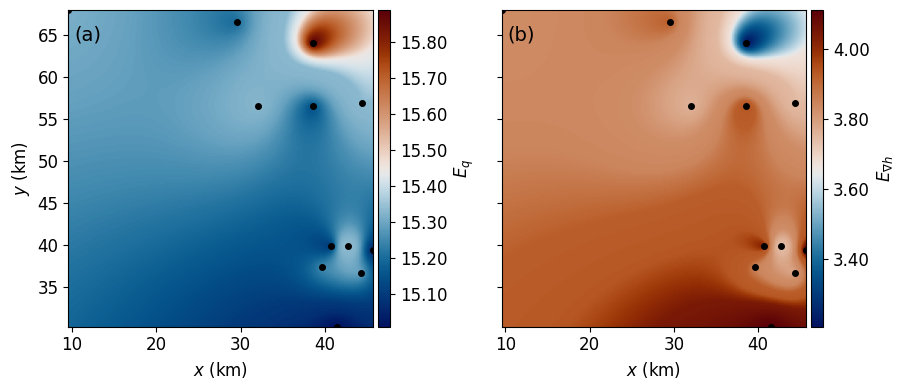

In [421]:
import numpy as np
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable

cmap = cmc.vik     # ← use batlow; revert to vik if desired
fmt = FormatStrFormatter('%.2f')   # ← 2 decimal places
ax_ticksize  = 12
cbar_ticksize = 12
cbar_labelsize= 12

# -------- 1. take logarithm ------------------------------
Eq_plot = np.log10(Eq_median)     # or Eq_mean
Eg_plot = np.log10(Eg_median)
Eq_plot = np.ma.masked_invalid(Eq_plot)
Eg_plot = np.ma.masked_invalid(Eg_plot)

fig, ax = plt.subplots(1, 2, figsize=(10,4), sharey=True)

# ------------ (a) E_q ---------------------------
im0 = ax[0].imshow(Eq_median, origin='lower',
          extent=[xmin_km,xmax_km,ymin_km,ymax_km],
          cmap=cmap)
ax[0].scatter(well['x'], well['y'], c='k', s=16)
ax[0].text(0.02, 0.95, '(a)', transform=ax[0].transAxes,
      fontsize=14, va='top')

div0 = make_axes_locatable(ax[0])        # ⬅ same-height colorbar
cax0 = div0.append_axes("right", size="4%", pad=0.05)
cbar0 = fig.colorbar(im0, cax=cax0)
cax0.yaxis.set_major_formatter(fmt)       # ⬅ decimal places
cax0.tick_params(labelsize=cbar_ticksize)
cbar0.ax.set_ylabel(r'$E_q$',
          fontsize=cbar_labelsize)

# ------------ (b) E_grad ------------------------
im1 = ax[1].imshow(Eg_median, origin='lower',
          extent=[xmin_km,xmax_km,ymin_km,ymax_km],
          cmap=cmap)
ax[1].scatter(well['x'], well['y'], c='k', s=16)
ax[1].text(0.02, 0.95, '(b)', transform=ax[1].transAxes,
      fontsize=14, va='top')

div1 = make_axes_locatable(ax[1])
cax1 = div1.append_axes("right", size="4%", pad=0.05)
cbar1 = fig.colorbar(im1, cax=cax1)
cax1.yaxis.set_major_formatter(fmt)
cax1.tick_params(labelsize=cbar_ticksize)
cbar1.ax.set_ylabel(r'$E_{\nabla h}$',
          fontsize=cbar_labelsize)

# ---- common axis label & tick size -----------------------
for a in ax:
  a.set_xlabel('$x$ (km)', fontsize=12)
  a.tick_params(axis='both', labelsize=ax_ticksize)
ax[0].set_ylabel('$y$ (km)', fontsize=12)

plt.tight_layout()
fig.subplots_adjust(wspace=0.04, left=0.07, right=0.92)
plt.savefig('Energy_maps.pdf', dpi=300)  # or 
plt.show()


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import rankdata, norm
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import distance_matrix
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.linalg import cho_factor, cho_solve
from scipy.spatial import cKDTree

def copula_interpolation_wrapper(data, grid_x, grid_y, n_neighbors=100, k=20000, variogram_lag_step=0.1, plot_variogram=False):
  """
  Perform Copula interpolation for the given grid.
  
  Parameters:
  data : pd.DataFrame，must contain x, y, z columns
  grid_x, grid_y : grid coordinates generated by np.meshgrid
  n_neighbors : number of nearest neighbors during interpolation (default=20)
  k : number of discrete points for Copula interpolation (default=500)
  variogram_lag_step : step size for empirical variogram (default=1)
  
  Output:
  copula_z_a : grid of expected values after interpolation (same size as grid_x, grid_y)
  copula_z_m : grid of median values after interpolation (same size as grid_x, grid_y)
  """
  
  # ensure data has x, y, z columns
  if not all(col in data.columns for col in ['x', 'y', 'z']):
    raise ValueError("data must contain 'x', 'y', 'z' columns")
  
  # Copula transform
  data = data.copy()
  data['u'] = rankdata(data['z'], method='average') / (len(data['z']) + 1)
  data['z_prime'] = norm.ppf(data['u'])
  
  # compute pairwise distance and get max_lag
  distances = pdist(data[['x', 'y']].values)
  max_lag = np.percentile(distances, 90) # use 90th percentile as max_lag
  print(f'max lag is {max_lag}')
  
  # compute empirical variogram
  def empirical_variogram(d, lag_step, max_lag):
    coords = d[['x', 'y']].values
    values = d['z_prime'].values
    num_bins = int(max_lag / lag_step)
    bins = np.linspace(0, max_lag, num_bins + 1)
    gamma_empirical = np.zeros(num_bins)
    counts = np.zeros(num_bins)

    for i in range(len(coords)):
      for j in range(i + 1, len(coords)):
        h = np.linalg.norm(coords[i] - coords[j])
        gamma = 0.5 * (values[i] - values[j])**2
        for b in range(num_bins):
          if bins[b] <= h < bins[b + 1]:
            gamma_empirical[b] += gamma
            counts[b] += 1

    gamma_empirical = np.divide(gamma_empirical, counts, out=np.zeros_like(gamma_empirical), where=counts > 0)
    return bins[:-1] + lag_step / 2, gamma_empirical
  
  h_empirical, gamma_empirical = empirical_variogram(data, variogram_lag_step, max_lag)
  
  # define theoretical variogram (exponential model)
  def theoretical_variogram(h, range_param):
    return 1 - np.exp(-h / range_param)
  
  # objective function for optimization
  def variogram_objective(range_param, h_e, g_e):
    g_t = theoretical_variogram(h_e, range_param)
    return np.sum((g_e - g_t)**2)
  
  # optimize range_param
  initial_range_param = 0.3
  result = minimize(
    variogram_objective,
    x0=initial_range_param,
    args=(h_empirical, gamma_empirical),
    bounds=[(0.01, max_lag)]
  )
  optimized_range_param = result.x[0]

  # if plotting, show empirical variogram and fitted theoretical one in a 1x2 subplot
  if plot_variogram:
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    # Left plot: empirical variogram and fitted theoretical variogram
    axes[0].scatter(h_empirical, gamma_empirical, color='blue', label='Empirical Variogram (Copula Domain)', alpha=0.7)
    h_theoretical = np.linspace(0, max_lag, 100)
    gamma_theoretical = theoretical_variogram(h_theoretical, optimized_range_param)
    axes[0].plot(h_theoretical, gamma_theoretical, color='red', 
          label=f'Theoretical Variogram\n(range_param={optimized_range_param:.2f})')
    axes[0].set_xlabel('Lag Distance (h)')
    axes[0].set_ylabel('Semivariance γ(h)')
    axes[0].set_title('Empirical vs. Fitted Theoretical Variogram')
    axes[0].legend()
    axes[0].grid(True)
    
    # Right plot: objective function at different range_param
    test_range_params = np.linspace(0.01, max_lag, 100)
    objective_values = [variogram_objective(rp, h_empirical, gamma_empirical) for rp in test_range_params]
    axes[1].plot(test_range_params, objective_values, color='green', label='Objective function')
    axes[1].axvline(optimized_range_param, color='red', linestyle='--', label='Optimized range_param')
    axes[1].set_xlabel('range_param')
    axes[1].set_ylabel('Objective function value')
    axes[1].set_title('Variogram Objective Function vs. range_param')
    axes[1].grid(True)
    axes[1].legend()
    
    # adjust layout and show
    plt.tight_layout()
    plt.show()
  
  # build KD-Tree for fast nearest neighbor search
  tree = cKDTree(data[['x', 'y']].values)
  
  # define Copula interpolation function
  def copula_interpolation(x0, y0, d, n=n_neighbors, k=k):
    n = min(n, len(d))
    _, indices = tree.query([x0, y0], k=n)
    nearest_data = d.iloc[indices].reset_index(drop=True)
    
    # z_prime of nearest points
    z_prime_observed = nearest_data['z_prime'].values
    
    # define discrete grid of u and z_prime
    u_values = np.linspace(1/(2*k), 1 - 1/(2*k), k)
    z_prime_values = norm.ppf(u_values)
    
    # define covariance function (exponential model, cov = exp(-h/range_param))
    def exponential_covariance(h, range_param=optimized_range_param):
      return np.exp(-h / range_param)
    
    coords = nearest_data[['x', 'y']].values
    dist_matrix = distance_matrix(coords, coords)
    
    # build covariance matrix gamma
    gamma = exponential_covariance(dist_matrix)
    
    # compute distance vector to interpolation point
    dist_to_point = np.sqrt((nearest_data['x'] - x0)**2 + (nearest_data['y'] - y0)**2)
    gamma_s = exponential_covariance(dist_to_point)
    
    # solve linear system via Cholesky decomposition
    L, lower = cho_factor(gamma)
    Gamma_22_inv = cho_solve((L, lower), np.eye(len(gamma)))
    
    # obtain conditional mean and variance
    mu_c = gamma_s @ Gamma_22_inv @ z_prime_observed
    sigma_c2 = 1 - gamma_s @ Gamma_22_inv @ gamma_s.T
    sigma_c2 = max(sigma_c2, 1e-4)
    
    # compute conditional density phi_cond
    phi_zp = norm.pdf(z_prime_values)
    phi_cond = norm.pdf(z_prime_values, loc=mu_c, scale=np.sqrt(sigma_c2))
    cs_n = phi_cond / phi_zp
    
    # compute conditional CDF
    delta_u = u_values[1] - u_values[0]
    Cs_n = np.cumsum(cs_n * delta_u)
    
    # build inverse function between original u and z
    z_sorted = np.sort(d['z'])
    u_sorted = np.linspace(1/(len(z_sorted)+1), len(z_sorted)/(len(z_sorted)+1), len(z_sorted))
    F_inv = interp1d(u_sorted, z_sorted, bounds_error=False, fill_value=(z_sorted[0], z_sorted[-1]))
    
    z_values = F_inv(u_values)
    
    # compute expected value
    z_star_a = np.sum(z_values * cs_n * delta_u)
    
    # compute median
    u_median = 0.5
    F_inv_cdf = interp1d(Cs_n, z_values, bounds_error=False, fill_value=(z_values[0], z_values[-1]))
    z_star_m = F_inv_cdf(u_median)
    variance = sigma_c2

    cdf_csn = np.cumsum(cs_n * delta_u)

    lower_bound = F_inv(u_values[np.searchsorted(cdf_csn, 0.025)])
    upper_bound = F_inv(u_values[np.searchsorted(cdf_csn, 0.975)])
    
    return z_star_a, z_star_m, variance, lower_bound, upper_bound
  
  # interpolate over grid points
  grid_points = np.c_[grid_x.ravel(), grid_y.ravel()]
  results = np.array([copula_interpolation(xg, yg, data) for xg, yg in grid_points])
  
  copula_z_a = results[:, 0].reshape(grid_x.shape)
  copula_z_m = results[:, 1].reshape(grid_x.shape)
  copula_variance = results[:, 2].reshape(grid_x.shape)
  copula_lower = results[:, 3].reshape(grid_x.shape)
  copula_upper = results[:, 4].reshape(grid_x.shape)
  return copula_z_a, copula_z_m, copula_variance, copula_lower, copula_upper
